# Build Azure OpenAI Client

In [1]:
# We will need this version of Azure OpenAI
%pip install openai==1.12.0

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 8, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 34.0 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Not uninstalling typing-extensions at /home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages, outside environment /nfs4/pyenv-58edf977-c13a-4941-aaef-4da1d1bb5aae
    Can't uninstall 'typing_extensions'. No files were found to uninstall.
  Attempting uninstall: openai
    Found existing installation: openai 0.27.8
    Not uninstalling openai at /home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages, outside environment /nfs4/pyenv-58edf977-c13a-4941-aaef-4da1d1bb5aae
    Can't uninstall 'openai'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into accoun

In [2]:
from openai import AzureOpenAI
import json

# Get keys and instantiate Azure OpenAI Client
with open('/lakehouse/default/Files/keys/aoai_key.json','r') as f:
    content = json.load(f)

ENDPOINT_URL = content.get('API_ENDPOINT')
API_KEY = content.get('API_KEY')
API_VERSION = '2023-09-01-preview'
OPENAI_EMBEDDING_ENGINE = 'text-embedding-ada-002'

client = AzureOpenAI(
    azure_endpoint=ENDPOINT_URL,
    api_key=API_KEY,
    api_version=API_VERSION,
)

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 10, Finished, Available)

# Generate Semantic Embeddings Based on Summary

In [3]:
# Get embeddings from text
def get_embedding_from_json(json_doc):

    summary = json_doc['summary']
    
    query_embeddings = client.embeddings.create(model=OPENAI_EMBEDDING_ENGINE, input=summary, encoding_format='float')
    embedding = query_embeddings.data[0].embedding

    return embedding

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 11, Finished, Available)

In [13]:
# Load and enrich JSON
import os

enrich_json_docs = []
header_path = '/lakehouse/default/Files/book_enriched'

for file_name in os.listdir(header_path):
    file_path = os.path.join(header_path,file_name)

    # Open current file
    with open(file_path,'r') as f:
        json_content = f.read()
        json_doc = json.loads(json_content)
    
    embedding = get_embedding_from_json(json_doc)

    enriched_json_doc = {
        'embedding': embedding
    }

    json_doc.update(enriched_json_doc)

    # Write AI enriched data back to source
    with open(file_path,'w') as f:
        json.dump(json_doc,f, indent=4)
    
    print(f'Enriched {file_name}')
    enrich_json_docs.append(json_doc)


StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 21, Finished, Available)

Enriched 9.json
Enriched 181.json
Enriched 99.json
Enriched 136.json
Enriched 6.json
Enriched 216.json
Enriched 61.json
Enriched 230.json
Enriched 235.json
Enriched 109.json
Enriched 41.json
Enriched 39.json
Enriched 71.json
Enriched 237.json
Enriched 56.json
Enriched 156.json
Enriched 13.json
Enriched 229.json
Enriched 151.json
Enriched 3.json
Enriched 5.json
Enriched 49.json
Enriched 57.json
Enriched 117.json
Enriched 207.json
Enriched 8.json
Enriched 4.json
Enriched 104.json
Enriched 7.json
Enriched 2.json


# Create Semantic Similarities

Leveraging Cosine Similarity and TSNE

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 22, Finished, Available)

In [15]:
book_embeddings = [item['embedding'] for item in enrich_json_docs]

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 23, Finished, Available)

In [18]:
# Calculate cosine similarity (optional, but useful for comparison)
def cosine_similarity(embedding1, embedding2):
    dot_product = np.dot(embedding1, embedding2)
    norm1 = np.linalg.norm(embedding1)
    norm2 = np.linalg.norm(embedding2)
    return dot_product / (norm1 * norm2)

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 26, Finished, Available)

In [21]:
# Compute pairwise cosine similarity between embeddings
num_embeddings = len(book_embeddings)
cosine_matrix = np.zeros((num_embeddings, num_embeddings))
for i in range(num_embeddings):
    for j in range(i + 1, num_embeddings):
        similarity = cosine_similarity(book_embeddings[i], book_embeddings[j])
        cosine_matrix[i, j] = similarity
        cosine_matrix[j, i] = similarity

# Apply t-SNE to reduce dimensionality
embedded_matrix = np.array(book_embeddings)
tsne = TSNE(n_components=2, perplexity=1, random_state=0)
embedded_points = tsne.fit_transform(embedded_matrix)

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 29, Finished, Available)

2024-03-02:20:04:19,253 WARNING  [tracking_store.py:153] log_inputs not supported


StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 30, Finished, Available)

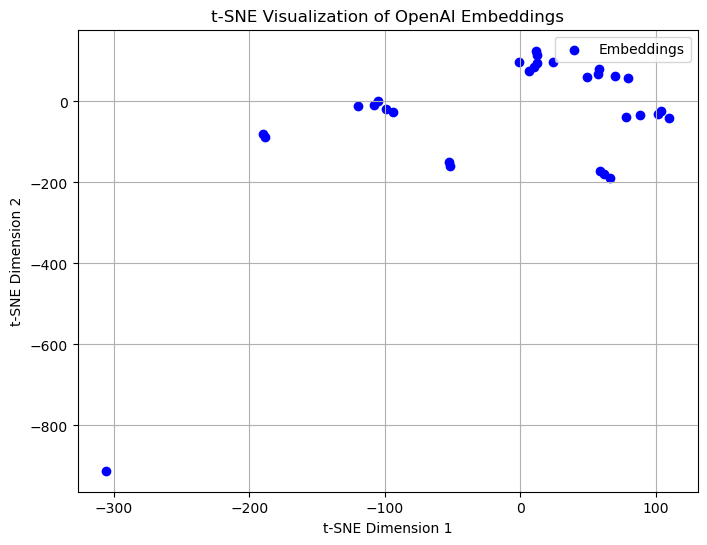

In [22]:
# Visualization
plt.figure(figsize=(8, 6))
plt.scatter(embedded_points[:, 0], embedded_points[:, 1], c='b', marker='o', label='Embeddings')
plt.title('t-SNE Visualization of OpenAI Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.legend()
plt.grid(True)
plt.show()

In [30]:
books_ids = [item['book_id'] for item in enrich_json_docs]
x_axes = [float(item[0]) for item in embedded_points]
y_axes = [float(item[1]) for item in embedded_points]

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 38, Finished, Available)

In [33]:
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType

# Specify schmea
table_schema = StructType([
    StructField('book_id', IntegerType(), True),
    StructField('x_axis', FloatType(), False),
    StructField('y_axis', FloatType(), False)
])

# Create the DataFrame
similarity_df = spark.createDataFrame(zip(books_ids, x_axes, y_axes), schema=table_schema)

display(similarity_df.limit(5))
similarity_df.createOrReplaceTempView('book_similarities')

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 41, Finished, Available)

SynapseWidget(Synapse.DataFrame, 457be032-d9de-478e-9fd9-2c43b0bba75e)

In [34]:
# Join df back to original table using SparkSQL
joined_df = spark.sql("""
    SELECT 
        B.*,
        BS.x_axis,
        BS.y_axis
    FROM gutenberg_lakehouse.books B
    JOIN book_similarities BS ON BS.book_id = B.book_id
""")

display(joined_df.limit(5))

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 42, Finished, Available)

SynapseWidget(Synapse.DataFrame, 0b42200d-9eb4-4210-8f79-b87eacc68e18)

In [35]:
joined_df.write.format('delta').mode('overwrite').option('overwriteSchema','true').saveAsTable('books')

StatementMeta(, 5be32b44-79cc-4e19-b528-fe01ef20286e, 43, Finished, Available)